In [2]:
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import seaborn as sns

Firstly, we need to set our parameters. What type of distributions do we use?

## Econ Courses

For EC100, appears to be a normal distribution with mean ~ 67, SD ~ 10.5.

![images/EC100.png](images/EC100.png)

EC102 has varied a lot more YoY, for reasons I am not too sure about. Pre-COVID, average was 65, post-COVID is 68-69. SD around 12.

![images/EC102.png](images/EC102.png)

## Maths Department

MA100: seems to be very flat distribution, with varying means. Before COVID, mean was around 60%. Now 67% or more, 72% in 2021. SD 19 pre-COVID, 14 post-COVID.

![images/MA100.png](images/MA100.png)

MA107: mean around 68, SD around 17.

![images/MA107.png](images/MA107.png)

## Statistics

For ST102, there was an anomaly in 2019/20. Otherwise, mean is 68, SD is 15-19 (say 17).

![images/ST102.png](images/ST102.png)

Based on the above, we set the variables below. That said, it really shouldn't matter. We can see that a lot of these distributions are roughly normal.

Clear trends during online exams:
- Greater $\mu$, could be do to with 'easier' exams or collaboration increasing scores for some.
- A smaller $\sigma$ - less variance with the higher mean also means more people getting a first.

Because grade distributions are not perfectly symmetrical and normal, we will need to use a skewed normal distribution to simulate scores.

To calculate the skew factor, I used the Pearson Median Skewness Coefficient. Median, mean and SD are provided in LSE's statistics data, so this was the most suitable.

These distributions are negatively skewed (few people get 90+ scores and there is a tail on the left). I created the simple function below to brute force the best distribution given a median, $\mu, $\sigma$, and required size. The default is negatively skewed distributions, though this be modified through another argument.

The distributions are generated through Seaborn's skewnorm rvs function.

In [ ]:
def skew_norm(n, mean, stdev, median, skew = -1):
    # create the skew coeff:
    skew_coeff = skew*3*(mean-median)/stdev
    plot_mean = mean
    acc = 3
    skew_dist = stats.skewnorm.rvs(a=skew_coeff, size = n, loc = plot_mean, scale = stdev)
    while(round(np.mean(skew_dist), acc) != mean):
        if(round(np.mean(skew_dist), acc)<mean):
            plot_mean+=10**(-1*acc -1)
        if(round(np.mean(skew_dist), acc) > mean):
            plot_mean-=10**(-1*acc -1)
        skew_dist = stats.skewnorm.rvs(a=skew_coeff,size = n, loc = plot_mean, scale = stdev)
        #print(np.mean(skew_dist))
    return skew_dist

In [31]:
true_mean = 67
median = 62
stdev = 14
n = 1000
first_mark = 70
skew_coeff = -3*(mean-median)/stdev #negative as this is negatively skewed
print(skew_coeff)

-1.0714285714285714


In [51]:
# # we can create a 'random' normal distribution to simulate n people taking exams.
# plot_mean = 60
# norm_exam = stats.skewnorm.rvs(a=skew_coeff,size = n, loc = plot_mean, scale = stdev)

norm_exam = skew_norm(n=1000, mean=67,stdev=14, median=14)
print(np.mean(norm_exam))


67.00001603301438


Text(0.5, 0, 'Exam Score')

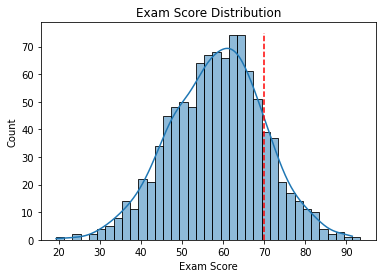

In [26]:
norm_exam_plt = sns.histplot(x=norm_exam, binwidth = 2, kde = True, stat='count', label = 'Exam Dist')
plt.vlines(first_mark, 0, 75, color='r', label='First', colors="r", linestyles='dashed')
plt.title('Exam Score Distribution')
plt.xlabel('Exam Score')

Extract the KDE so that we can calculate cumulative distributions and the like.

In [28]:
x = np.sort(norm_exam)
cdf_values = np.arange(n) / n
first_cdf = 1 - np.interp(70,x, cdf_values)
print(first_cdf)
print(np.mean(norm_exam))

0.1460469147938004
58.512461682448546


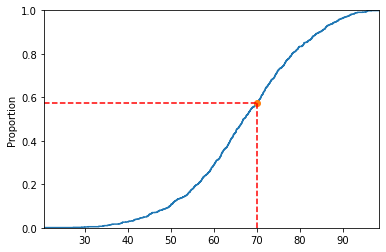

In [7]:
sns.ecdfplot(data=norm_exam)
# plt.vlines(first_mark, 0, 1, color='r', label='First', colors="r", linestyles='dashed')
plt.plot([first_mark], [1-first_cdf], marker = 'o')
plt.hlines(y=1-first_cdf, xmin=np.interp(0, cdf_values, x), xmax=first_mark,colors='red',linestyles='dashed')
plt.vlines(x=first_mark, ymin=0, ymax = 1-first_cdf, colors= 'red', linestyles='dashed')
plt.margins(0)

around 40% of students get a first with our current $\mu$ and $\sigma$

With COVID, it seems we have two trends:
- first, there has been an increase in the $\mu$. This is possibly because of ease of exams now that students have access to course materials, but it may also be due to academic dishonesty - for example, as students collaborate, they bring up poorer performing student, or might be able to write better-prepared answers. It may also be a case of 'divide and conquer.'
- Secondly, we see a lower SD. Access to course materials may mean lower threshold for writing good answers. There is also more time which will benefit those who are not as 'quick-thinking.' And as above, poorer-performing students who collaborate will be given a bridge to a better score, lowering the variance.

To incorporate this into our model, we can create two distributions - one for standard students (with the preexisting mean and variance), and one for cheaters. We can assume an $x$ proportion of students cheat on their exams.

In [8]:
prop_cheats = 0.2

In [9]:
cheat_mean = mean*1.1
cheat_stdev = stdev*0.9

# simulate cheat exams
cheat_scores = stats.norm.rvs(size = round(n*prop_cheats), loc = cheat_mean, scale = cheat_stdev)

# need to ensure that the values are within the parameters of our discussion; that is, exam score must be b/w 0 and 100. - this implementation might be slightly statistically flawed. alternative is to set all values below 0 to 0, all values above 100 to 100. 
for score in np.nditer(cheat_scores, op_flags=['readwrite']):
    while score > 100.0:
        x = stats.norm.rvs(loc = cheat_mean, scale = cheat_stdev, size = 1)
        score[...] = np.mean(x)
    while score <0:
        x = stats.norm.rvs(loc = cheat_mean, scale = cheat_stdev, size = 1)
        score[...] = np.mean(x)


In [10]:
honest_scores = stats.norm.rvs(size = round((1-prop_cheats)*n), loc = mean, scale = stdev)

for score in np.nditer(honest_scores, op_flags=['readwrite']):
    while score > 100.0:
        x = stats.norm.rvs(loc = mean, scale = stdev, size = 1)
        score[...] = np.mean(x)
    while score <0:
        x = stats.norm.rvs(loc = mean, scale = stdev, size = 1)
        score[...] = np.mean(x)

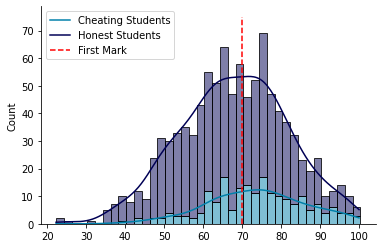

In [11]:
sns.histplot([honest_scores, cheat_scores], binwidth=2, kde=True, stat = 'count', label = 'Exam Dist', palette = 'ocean', multiple = 'stack')
plt.vlines(first_mark, 0, 75, color='r', label='First', colors="r", linestyles='dashed')
plt.legend(['Cheating Students', 'Honest Students', 'First Mark'], loc = 2)
sns.despine()

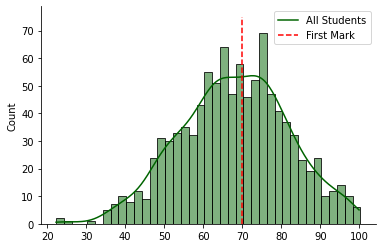

In [12]:
total_scores = np.append(honest_scores, cheat_scores)
sns.histplot(x=total_scores, binwidth=2, kde = True, stat = 'count', label = 'Exam Dist', color = 'darkgreen')
plt.vlines(first_mark, 0, 75, color='r', label='First', colors="r", linestyles='dashed')
sns.despine()
plt.legend(['All Students', 'First Mark'])

Can see now a lot more students are getting firsts! Looks like > 50%, but we can confirm below:

In [13]:
all_x = np.sort(total_scores)
all_cdf = np.arange(n) / n
all_first = 1 - np.interp(first_mark,all_x,all_cdf)

honest_x = np.sort(honest_scores)
honest_cdf = np.arange((1-prop_cheats)*n)/((1-prop_cheats)*n)
honest_first = 1- np.interp(first_mark, honest_x, honest_cdf)

cheat_x = np.sort(cheat_scores)
cheat_cdf = np.arange((prop_cheats)*n)/((prop_cheats)*n)
cheat_first = 1- np.interp(first_mark, cheat_x, cheat_cdf)

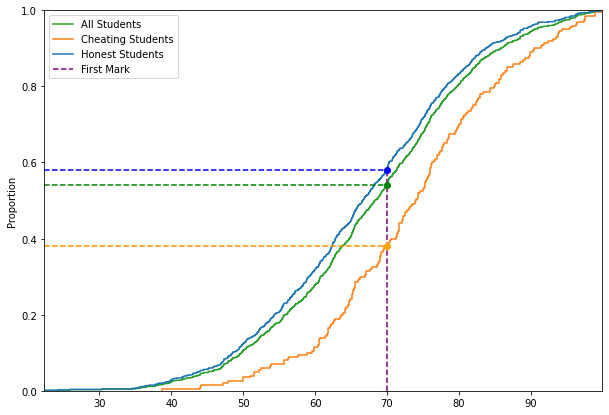

In [14]:
plt.figure(figsize=(10,7))
sns.ecdfplot([honest_scores,cheat_scores, total_scores])
plt.vlines(x=first_mark, ymin=0, ymax = 1-honest_first, colors= 'purple', linestyles='dashed')
plt.hlines(y=1-all_first, xmin=np.interp(0, all_cdf, all_x), xmax=first_mark,colors='green',linestyles='dashed')
plt.hlines(y=1-honest_first, xmin=np.interp(0, all_cdf, all_x), xmax=first_mark,colors='blue',linestyles='dashed')
plt.hlines(y=1-cheat_first, xmin=np.interp(0, all_cdf, all_x), xmax=first_mark,colors='darkorange',linestyles='dashed')
plt.plot([first_mark], [1-all_first], marker = 'o', color = 'green', linestyle = 'dashed')
plt.plot([first_mark], [1-honest_first], marker = 'o', color = 'blue', linestyle = 'dashed')
plt.plot([first_mark], [1-cheat_first], marker = 'o', color = 'orange', linestyle = 'dashed')
plt.margins(0)
plt.legend(['All Students','Cheating Students','Honest Students', 'First Mark'])


In [15]:
print(str(round(100*all_first, 2)) + '% of all students get a first.')
print(str(round(100*honest_first, 2)) + '% of honest students get a first.')
print(str(round(100*cheat_first, 2)) + '% of cheat students get a first.')

45.82% of all students get a first.
41.9% of honest students get a first.
61.92% of cheat students get a first.


We can see here a great discrepancy between cheat scores and honest scores. The effect that this has on the total scores seems less profound, as the curve only slightly strays away from the honest curve (which should be similar to what we saw in the general example). However, we can clearly see that there is a significant amount of grade inflation. Previously, only 40% of students got firsts - now, it is 46%. I didn't add in one element which was regular students performing better too, possibly because of access to course materials. If we account for this:

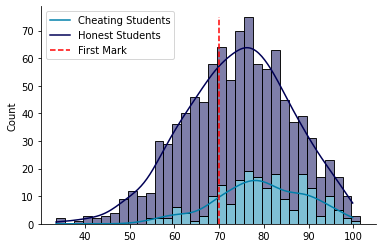

In [16]:
new_honest_mean = 1.10*mean
new_honest_stdev = 0.9*stdev
new_cheat_mean = 1.1*new_honest_mean
new_cheat_stdev = 0.9*new_honest_stdev

new_honest_scores = stats.norm.rvs(size = round(n*(1-prop_cheats)), loc = new_honest_mean, scale = new_honest_stdev)
new_cheat_scores = stats.norm.rvs(size = round(n*prop_cheats), loc = new_cheat_mean, scale = new_cheat_stdev)

# need to ensure that the values are within the parameters of our discussion; that is, exam score must be b/w 0 and 100. - this implementation might be slightly statistically flawed. alternative is to set all values below 0 to 0, all values above 100 to 100. 

for score in np.nditer(new_honest_scores, op_flags=['readwrite']):
    while score > 100.0:
        x = stats.norm.rvs(loc = new_honest_mean, scale = new_honest_stdev, size = 1)
        score[...] = np.mean(x)
    while score <0:
        x = stats.norm.rvs(loc = new_honest_mean, scale = new_honest_stdev, size = 1)
        score[...] = np.mean(x)

for score in np.nditer(new_cheat_scores, op_flags=['readwrite']):
    while score > 100.0:
        x = stats.norm.rvs(loc = new_cheat_mean, scale = new_cheat_stdev, size = 1)
        score[...] = np.mean(x)
    while score <0:
        x = stats.norm.rvs(loc = new_cheat_mean, scale = new_cheat_stdev, size = 1)
        score[...] = np.mean(x)

new_total_scores = np.append(new_honest_scores, new_cheat_scores)

sns.histplot([new_honest_scores, new_cheat_scores], binwidth=2, kde=True, stat = 'count', label = 'Exam Dist', palette = 'ocean', multiple = 'stack')
plt.vlines(first_mark, 0, 75, color='r', label='First', colors="r", linestyles='dashed')
plt.legend(['Cheating Students', 'Honest Students', 'First Mark'], loc = 2)
sns.despine()

In [17]:
new_all_x = np.sort(new_total_scores)
new_all_cdf = np.arange(n) / n
new_all_first = 1 - np.interp(first_mark,new_all_x,new_all_cdf)

new_honest_x = np.sort(new_honest_scores)
new_honest_cdf = np.arange((1-prop_cheats)*n)/((1-prop_cheats)*n)
new_honest_first = 1- np.interp(first_mark, new_honest_x, new_honest_cdf)

new_cheat_x = np.sort(new_cheat_scores)
new_cheat_cdf = np.arange((prop_cheats)*n)/((prop_cheats)*n)
new_cheat_first = 1- np.interp(first_mark, new_cheat_x, new_cheat_cdf)

Text(0.5, 1.0, 'Effects of Online Exams')

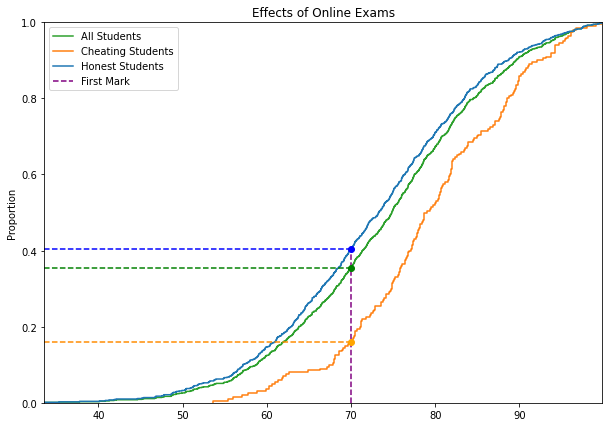

In [18]:
plt.figure(figsize=(10,7))
sns.ecdfplot([new_honest_scores,new_cheat_scores, new_total_scores])
plt.vlines(x=first_mark, ymin=0, ymax = 1-new_honest_first, colors= 'purple', linestyles='dashed')
plt.hlines(y=1-new_all_first, xmin=np.interp(0, new_all_cdf, new_all_x), xmax=first_mark,colors='green',linestyles='dashed')
plt.hlines(y=1-new_honest_first, xmin=np.interp(0, new_all_cdf, new_all_x), xmax=first_mark,colors='blue',linestyles='dashed')
plt.hlines(y=1-new_cheat_first, xmin=np.interp(0, new_all_cdf, new_all_x), xmax=first_mark,colors='darkorange',linestyles='dashed')
plt.plot([first_mark], [1-new_all_first], marker = 'o', color = 'green', linestyle = 'dashed')
plt.plot([first_mark], [1-new_honest_first], marker = 'o', color = 'blue', linestyle = 'dashed')
plt.plot([first_mark], [1-new_cheat_first], marker = 'o', color = 'orange', linestyle = 'dashed')
plt.margins(0)
plt.legend(['All Students','Cheating Students','Honest Students', 'First Mark'])
plt.title('Effects of Online Exams')

In [19]:
print('After COVID: \n')
print(str(round(100*new_all_first, 2)) + '% of all students get a first.')
print(str(round(100*new_honest_first, 2)) + '% of honest students get a first.')
print(str(round(100*new_cheat_first, 2)) + '% of cheat students get a first.')

After COVID: 

64.5% of all students get a first.
59.62% of honest students get a first.
84.13% of cheat students get a first.


We can see pretty clearly now how grade inflation arises. Again, this is due to two forces that are both in play - firstly, honest students have more resources at hand, so they are able to perform better on exams. Previously, only 40% of students could achieve a first. Now, through just a 10% improvement in performance from this factor, 60% of honest students get firsts! Access to course materials and notes becomes a 'great equaliser' which reduces the SD, improving performance more than just the $\mu$ itself.

Secondly, students are cheating on exams. Though this is not all students, it is reasonable to assume that this occurs for a significant minority, which I have attributed to $var \: prop\_cheats = 0.2$. Because students collaborate, they are able to achieve results far better than honest students. Despite accounting for a small percentage, these students score so well that they bring up averages significantly. Though only 60% of honest students got a first, 65% of all students got a first - that's because almost all cheaters could get first.

## Evaluation of the Model

Is this model appropriate for measuring student performance? It is certainly a reasonable explanation for why exam scores have increased off late. Undeniably, students can perform better with resources and time at their disposal compared to in examination-hall conditions. There should also be no doubt that collaboration on examinations (which occurs in both timed and 24-hour assessments) will increase performance - more brains will translate to better scores.

However, these results only apply for when online examinations are the same as their in-person counterparts. To what extent to these examinations differ, and how does it counter some of the effects we have seen above?

### Differences between in-person and online examinations

This is a question that LSE Exam boards and lecturers are more suited to answer. From my understanding, there are two types of exams:

- **Timed exams**:  These are synchronous such that all students do them at the same time, with a limited time frame including a generous amount for submission on a portal. These do not differ much (if at all) from regular exams, as students are not expected to have enough time to reference course material (though this is not necessarily the case).
- **24 Hour-Style Assessments**: These are to be taken with a longer window (often 24-hours) but the expected effort for these exams is far less. Many students will spend more than the expected effort on these exams.

In both of these exams, the two phenonmenon previously discussed occur. Even in timed exams, students may have enough time to reference their course materials, especially because of the additional submission time. Students can also collaborate on timed exams by taking them at the same location concurrently. Though I have not looked at data of exmaination scores for primarily timed assessments, I would assume that there is some level of grade inflation in these, too.

In 24-hour assessments, examiners can make the exam more difficult. However, some examples of this in MA107 and MA100 (see stats above) indicate that there is still some grade inflation occurring which the exam-writer has not been able to account for in the difficulty of the assessment. Students spend longer than the expected effort on these exams, which may be able to earn them a better score. Of course, cheating will still occur, too, if not be more rampant due to the longer timeframe.

The question, then, is what to do about it? It is not just the LSE, keen on maintaining the school's reputation, which is interested in quashing grade inflation. Indeed, the [UK Government](https://www.gov.uk/government/news/universities-told-to-end-grade-inflation) has wanted to reduce grade inflation even before the COVID-era had begun.

It is no easy question to answer. I'm sure the LSE has given this a lot of thought, particularly as the pandemic turned examinations online. It is difficult, if not near-on impossible, to develop examinations which are administered online and yet distinguish excelling students from mediocre ones who have a textbook open. This is especially true for timed exams, where the exam content is identical to that of an in-person exam. Examiners cannot write harder questions which require a further application of the course content to answer well.

If the LSE wishes to assess students through an online medium, it may realise that exams are not necessarily the best mode for that. Though changing assessment types is very challenging to accomplish successfully (and not practical where last-minute changes occur such as in the recent examination window), an assessment like a report may be a better representation of a student's understanding than an online exam-like assessment.

In these last-minute cases, however, there is not much the LSE can do. I imagine that the LSE has been reserving curving assessments as a tool of last-resort. Let me thus attempt to show the effects of assessment curves, who benefits, and who loses out.


In [20]:
# say the LSE wants to curve the exam so now only 50% of all people get a first. Before COVID, was ~ 40%. Increased after COVID substantially. 

In [21]:
curve_first_mark = np.interp(0.5, new_all_cdf, new_all_x)
print(curve_first_mark)

74.86487120706197


Text(0.5, 1.0, 'Effects of Online Exams')

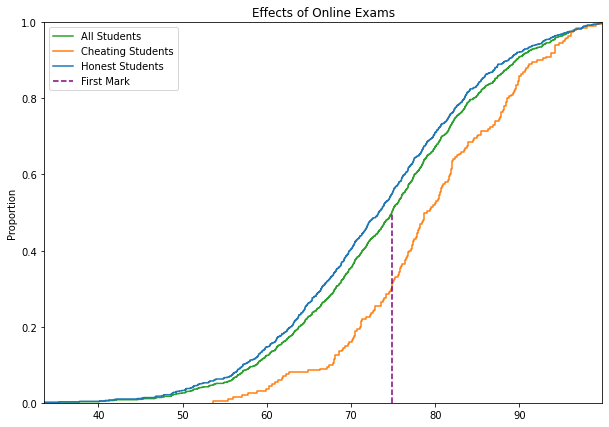

In [22]:
plt.figure(figsize=(10,7))
sns.ecdfplot([new_honest_scores,new_cheat_scores, new_total_scores])
plt.vlines(x=curve_first_mark, ymin=0, ymax = 0.5, colors= 'purple', linestyles='dashed')
#plt.hlines(y=1-new_all_first, xmin=np.interp(0, new_all_cdf, new_all_x), xmax=first_mark,colors='green',linestyles='dashed')
#plt.hlines(y=1-new_honest_first, xmin=np.interp(0, new_all_cdf, new_all_x), xmax=first_mark,colors='blue',linestyles='dashed')
#plt.hlines(y=1-new_cheat_first, xmin=np.interp(0, new_all_cdf, new_all_x), xmax=first_mark,colors='darkorange',linestyles='dashed')
# plt.plot([first_mark], [1-new_all_first], marker = 'o', color = 'green', linestyle = 'dashed')
# plt.plot([first_mark], [1-new_honest_first], marker = 'o', color = 'blue', linestyle = 'dashed')
# plt.plot([first_mark], [1-new_cheat_first], marker = 'o', color = 'orange', linestyle = 'dashed')
plt.margins(0)
plt.legend(['All Students','Cheating Students','Honest Students', 'First Mark'])
plt.title('Effects of Online Exams')